# gd theano 進階版寫法

首先假設一個很簡單的function => y=x

1. 模擬資料一些資料從y=x產生
2. init weights
3. define model，真實世界裡的 <font color='red'>f</font> 我們是未知的，這裡我們當作已經知道是y=x，方便用來驗證gradient
4. define cost
5. implement SGD
6. training

In [35]:
import theano
import theano.tensor as T
import numpy as np
import matplotlib.pyplot as plt
import itertools as it

### 把floatX包起來方便使用

In [36]:
def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

### 模擬資料

In [37]:
x_data = floatX(np.array(np.linspace(-5.0, 5.0, 100)))
y_data = floatX(np.array(x_data))

### 初始化權重

In [38]:
w = theano.shared(floatX(np.array(-1.)))

### 定義model / function

這裡要特別注意，因為是跑SGD是一筆一筆資料跑而且我們資料只有一維，要將x宣告為theano <font color='red'>scalar()</font>

In [39]:
### model
x = T.scalar()
y = w*x

如果要測試model output可以theano function一下

In [40]:
f = theano.function([x], y)
print f(10)

-10.0


那如果x是二維或是多維以上呢?那就要將x宣告為theano <font color='red'>vector()</font>

In [41]:
#假設x是二維，w也要是二維(當然)
w2 = theano.shared(floatX(np.array([-1.,-1.])))
print "w2 我是vector"
print w2
print ""
x2 = theano.shared(floatX(np.array([1.,1.])))
print "x2 我也是vector"
print x2
print ""
print "Element Wise 相乘，我還是vector"
print (w2*x2).eval()
print (w2*x2).type()
print ""
print "矩陣相乘dot，我變成scalar了，這樣才能配合y_hat也是scalar，順利做gradient"
print (T.dot(w2,x2)).eval()
print (T.dot(w2,x2)).type()

w2 我是vector
<TensorType(float64, vector)>

x2 我也是vector
<TensorType(float64, vector)>

Element Wise 相乘，我還是vector
[-1. -1.]
<TensorType(float64, vector)>

矩陣相乘dot，我變成scalar了，這樣才能配合y_hat也是scalar，順利做gradient
-2.0
<TensorType(float64, scalar)>


### 實作SGD
* 用izip配合迴圈寫法一次update多個參數，如同下面寫法
* [w1, w1 - 0.01*dw1]
* [w2, w2 - 0.01*dw2]
* ...
* [b, b - 0.01*db]

In [42]:
### gradients
def sgd(params, grads, lr): 
    updates = []
    for p, g in it.izip(params, grads):      
        updates.append([p, p - lr*g])    
    return updates

### 定義cost/error/loss
#### 很重要，取決你怎麼餵資料算cost，SGD/MiniBatch/All Data cost算法都不一樣)

要特別注意cost function是<font color='red'>不用做sum</font>的(別找抄把全部data看過一輪的cost function)，因為是一筆做一次gradient

In [43]:
### cost/error/loss
y_hat = T.scalar()
#cost = T.sum((y-y_hat)**2)
cost = (y-y_hat)**2

### 定義train的theano function
* 對cost的w偏微分
* 輸入x, y_hat
* 輸出cost, w
* 更新用sgd

In [44]:
dw = T.grad(cost, w)
train = theano.function(inputs=[x, y_hat],
                        outputs=[cost,w],
                        updates=sgd([w], [dw], 0.001))

### 洗牌一下

In [45]:
# shuffle idx for Stochastic (不用作也沒關係，有可能data本身就是沒有順序性了)
idx = np.arange(x_data.shape[0])
np.random.shuffle(idx)

### 開始training

* cost_result第一個是cost變化，第二個是w的變化

In [46]:
# training
cost_list = []
for t in range(3):    
    for i in idx:
        cost_result = train(x_data[i], y_data[i])
        print cost_result
        cost_list.append(cost_result[0])

[array(24.497500255076016), array(-1.0)]
[array(18.40609663273038), array(-0.975502499744924)]
[array(1.1818928946746756), array(-0.9568681556880504)]
[array(14.838350789801055), array(-0.9556602123820701)]
[array(59.94384247011384), array(-0.9404854384659741)]
[array(6.56316710630522), array(-0.8787031222662692)]
[array(0.22340332428663073), array(-0.8717162098280888)]
[array(12.230445747680909), array(-0.8714774948742795)]
[array(72.95148397415828), array(-0.8584071311844372)]
[array(79.2008725195021), array(-0.7798974410847621)]
[array(2.6327764788322687), array(-0.6909025690305239)]
[array(2.099923721606711), array(-0.6877885203241674)]
[array(25.21901733863722), array(-0.6853001472888971)]
[array(52.905313985909835), array(-0.6553719266343075)]
[array(36.33954127018013), array(-0.5914523770337817)]
[array(24.190693634878276), array(-0.5457839777846488)]
[array(10.817739263835765), array(-0.5144850460030588)]
[array(14.931653919927001), array(-0.5001993463292518)]
[array(28.1761569

### 畫圖看結果

* SGD不是像GD一樣是看最陡的方向，而是取一筆後就走了，會亂跳，但是會慢慢收斂
* SGD比GD快(如果在GPU平行運算的環境下，反而是mini batch或all data比較快，因為矩陣相乘靠GPU平行運算下 (ref ML2016 Hello World of deep learning)

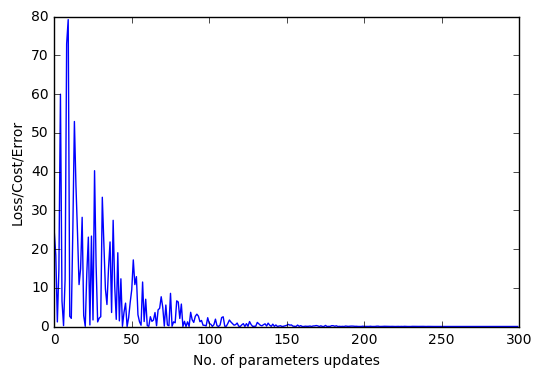

In [47]:
plt.plot(cost_list)
plt.xlabel("No. of parameters updates")
plt.ylabel("Loss/Cost/Error")
plt.show()

### 如果不做shuffle呢???

In [48]:
w = theano.shared(floatX(np.array(-1.)))

idx = np.arange(x_data.shape[0])

# training
cost_list = []
for t in range(3):    
    for i in idx:
        cost_result = train(x_data[i], y_data[i])
        print cost_result
        cost_list.append(cost_result[0])

[array(0.0031610265651050113), array(0.9887553985128773)]
[array(0.002738725059008596), array(0.9893176285872335)]
[array(0.002380816305290467), array(0.9898303845948997)]
[array(0.0020763654485852034), array(0.9902986060979658)]
[array(0.0018164550719730263), array(0.9907266611732576)]
[array(0.0015937864122843527), array(0.9911184197633212)]
[array(0.001402364197281175), array(0.9914773167996171)]
[array(0.0012372466447381754), array(0.9918064066330203)]
[array(0.0010943464289425182), array(0.9921084100616319)]
[array(0.000970271658781572), array(0.9923857550421717)]
[array(0.0008621983799539139), array(0.992640612001504)]
[array(0.0007677680021511846), array(0.9928749245231784)]
[array(0.0006850045019315554), array(0.9930904360653785)]
[array(0.0006122473692468727), array(0.9932887132673591)]
[array(0.0005480971295564714), array(0.9934711663180593)]
[array(0.0004913709438940553), array(0.9936390667904125)]
[array(0.00044106631127912595), array(0.9937935632857234)]
[array(0.000396331

### 結果好平滑，為什麼?

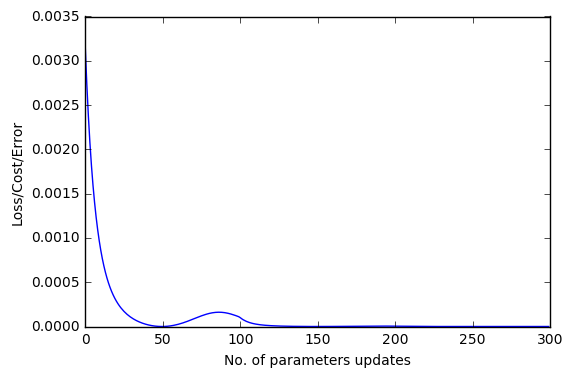

In [49]:
plt.plot(cost_list)
plt.xlabel("No. of parameters updates")
plt.ylabel("Loss/Cost/Error")
plt.show()

### 因為我們cost function是長這樣(convex)，我們是從最左邊慢慢往下走，而不是shuffle亂走，結果就會很平滑

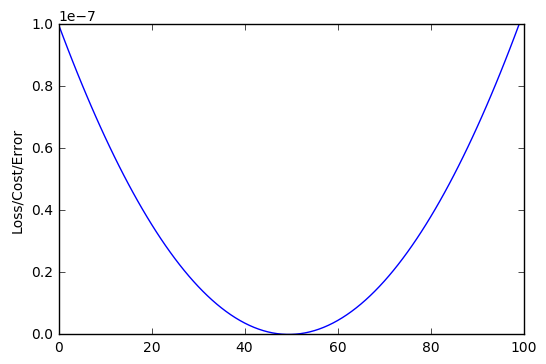

In [50]:
cost_f_list = []
cost_f = theano.function([x, y_hat], cost)
for i in range(x_data.shape[0]):
    cost_f_list.append(cost_f(x_data[i], y_data[i]))
    
plt.plot(cost_f_list)
plt.ylabel("Loss/Cost/Error")
plt.show()